In [1]:
!nvidia-smi

Tue Nov 17 15:19:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
import statistics as ss
from scipy.spatial import distance
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage import measure
import scipy.ndimage as ndi
import glob
from skimage.feature import corner_harris, corner_peaks
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import tqdm
from sklearn.model_selection import GridSearchCV

In [3]:
rcParams['figure.figsize'] = (12,12)

In [4]:
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/Colab Notebooks/100species/'
#link = 'https://drive.google.com/drive/folders/1qsdhTO5jbH-1g7Fjdtxx_VZOHOihcJrt'

Mounted at /content/gdrive


In [5]:
def get_coord(file):
    img = mpimg.imread(file)
    coords = corner_peaks(corner_harris(img), min_distance=5)
    cy, cx = ndi.center_of_mass(img)
    dist_x, dist_y, dist = [], [], []
    for i in range(len(coords)):
        dist_x.append(cx-coords[i][0])
        dist_y.append(cy-coords[i][1])
        dist.append(distance.euclidean((cx,cy),coords[i]))
    stdev_x = ss.stdev(dist_x)
    stdev_y = ss.stdev(dist_y)
    stdev_dist = ss.stdev(dist)
    avg_dist_x, avg_dist_y = 0,0
    for i in range(len(dist_x)):
        avg_dist_x = avg_dist_x + abs(dist_x[i])
        avg_dist_y = avg_dist_y + abs(dist_y[i])
    avg_dist_x = avg_dist_x/len(coords)
    avg_dist_y = avg_dist_y/len(coords)
    return [avg_dist_x, avg_dist_y, max(dist_x) - min(dist_x), max(dist_y) - min(dist_y), stdev_dist, stdev_x, stdev_y]

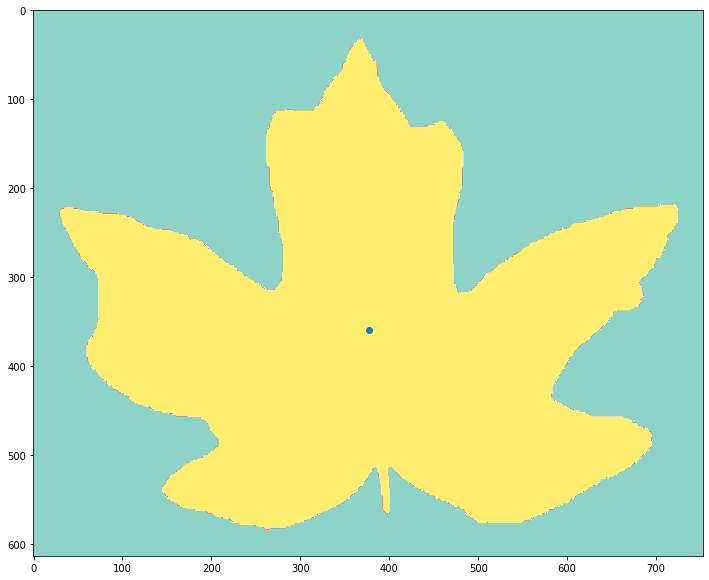

In [6]:
img = mpimg.imread(root_path+'data/Acer_Campestre/Acer_Campestre_01.ab.jpg')
cy, cx = ndi.center_of_mass(img)
plt.imshow(img, cmap='Set3')
plt.scatter(cx, cy)
plt.show()

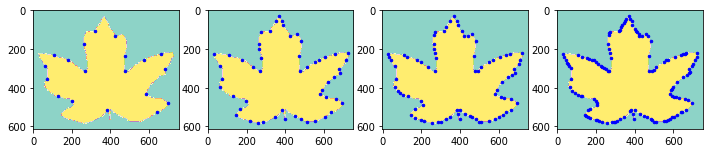

In [7]:
coords = corner_peaks(corner_harris(img), min_distance=50)
plt.subplot(1,4,1)
plt.imshow(img, cmap='Set3')
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)

coords = corner_peaks(corner_harris(img), min_distance=20)
plt.subplot(1,4,2)
plt.imshow(img, cmap='Set3')
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)

coords = corner_peaks(corner_harris(img), min_distance=10)
plt.subplot(1,4,3)
plt.imshow(img, cmap='Set3')
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)

coords = corner_peaks(corner_harris(img), min_distance=5)
plt.subplot(1,4,4)
plt.imshow(img, cmap='Set3')
plt.plot(coords[:, 1], coords[:, 0], '.b', markersize=5)
plt.show()

In [8]:
names = ['Acer_Campestre', 'Acer_Capillipes', 'Acer_Circinatum', 'Acer_Mono', 'Acer_Opalus', 'Acer_Palmatum', 'Acer_Pictum', 'Acer_Platanoids', 'Acer_Rubrum', 'Acer_Rufinerve', 'Acer_Saccharinum', 'Alnus_Cordata', 'Alnus_Maximowiczii', 'Alnus_Rubra', 'Alnus_Sieboldiana', 'Alnus_Viridis', 'Arundinaria_Simonii', 'Betula_Austrosinensis', 'Betula_Pendula', 'Callicarpa_Bodinieri', 'Castanea_Sativa', 'Celtis_Koraiensis', 'Cercis_Siliquastrum', 'Cornus_Chinensis', 'Cornus_Controversa', 'Cornus_Macrophylla', 'Cotinus_Coggygria', 'Crataegus_Monogyna', 'Cytisus_Battandieri', 'Eucalyptus_Glaucescens', 'Eucalyptus_Neglecta', 'Eucalyptus_Urnigera', 'Fagus_Sylvatica', 'Ginkgo_Biloba', 'Ilex_Aquifolium', 'Ilex_Cornuta', 'Liquidambar_Styraciflua', 'Liriodendron_Tulipifera', 'Lithocarpus_Cleistocarpus', 'Lithocarpus_Edulis', 'Magnolia_Heptapeta', 'Magnolia_Salicifolia', 'Morus_Nigra', 'Olea_Europaea', 'Phildelphus', 'Populus_Adenopoda', 'Populus_Grandidentata', 'Populus_Nigra', 'Prunus_Avium', 'Prunus_X_Shmittii', 'Pterocarya_Stenoptera', 'Quercus_Afares', 'Quercus_Agrifolia', 'Quercus_Alnifolia', 'Quercus_Brantii', 'Quercus_Canariensis', 'Quercus_Castaneifolia', 'Quercus_Cerris', 'Quercus_Chrysolepis', 'Quercus_Coccifera', 'Quercus_Coccinea', 'Quercus_Crassifolia', 'Quercus_Crassipes', 'Quercus_Dolicholepis', 'Quercus_Ellipsoidalis', 'Quercus_Greggii', 'Quercus_Hartwissiana', 'Quercus_Ilex', 'Quercus_Imbricaria', 'Quercus_Infectoria_sub', 'Quercus_Kewensis', 'Quercus_Nigra', 'Quercus_Palustris', 'Quercus_Phellos', 'Quercus_Phillyraeoides', 'Quercus_Pontica', 'Quercus_Pubescens', 'Quercus_Pyrenaica', 'Quercus_Rhysophylla', 'Quercus_Rubra', 'Quercus_Semecarpifolia', 'Quercus_Shumardii', 'Quercus_Suber', 'Quercus_Texana', 'Quercus_Trojana', 'Quercus_Variabilis', 'Quercus_Vulcanica', 'Quercus_x_Hispanica', 'Quercus_x_Turneri', 'Rhododendron_x_Russellianum', 'Salix_Fragilis', 'Salix_Intergra', 'Sorbus_Aria', 'Tilia_Oliveri', 'Tilia_Platyphyllos', 'Tilia_Tomentosa', 'Ulmus_Bergmanniana', 'Viburnum_Tinus', 'Viburnum_x_Rhytidophylloides', 'Zelkova_Serrata']
d = {}
for x in names:
    d["{}".format(x)] = glob.glob(os.path.join(root_path, 'data', x, '*.jpg'))
print(d['Acer_Campestre'][0])

gdrive/My Drive/Colab Notebooks/100species/data/Acer_Campestre/Acer_Campestre_14.ab.jpg


In [9]:
x = []
for i in names:
    for j in range(16):
        x.append(get_coord(d[i][j]))

#pd.DataFrame(x).to_csv(root_path + 'ftable.csv', index=False, sep=',', header=None)
feature_table = (pd.read_csv(root_path + 'ftable.csv', index_col=None, sep=',', header=None))
print(feature_table)

               0           1      2      3           4           5           6
0     172.302051  138.753898  593.0  617.0   57.341677  196.841116  171.904762
1     114.453133  123.286737  442.0  468.0   59.918140  137.116456  145.428421
2     106.091614  133.920570  456.0  448.0   51.151453  127.668922  151.840788
3     115.894463  197.154666  500.0  582.0   59.470929  134.267661  220.610798
4     130.725283  151.272521  494.0  590.0   58.296035  149.121688  183.246631
...          ...         ...    ...    ...         ...         ...         ...
1595  165.699671  217.491794  279.0  697.0  110.088340   98.160464  187.249464
1596  145.425465  247.416147  330.0  739.0  147.057903  113.366434  207.731984
1597  100.356166  183.150393  251.0  571.0  103.826505   85.877173  143.983782
1598  128.311884  204.036401  303.0  644.0  118.661301  106.858856  166.237712
1599  168.934972  273.292027  317.0  768.0  151.486963  109.840669  207.716359

[1600 rows x 7 columns]


In [10]:
result = []
for i in range(len(names)):
    for j in range(16):
        result = np.append(result,names[i])

In [11]:
test = glob.glob(root_path+'data/Acer_Capillipes/acer_capillipes_01.ab.jpg')
test_coord = [get_coord(test[0])]
pd.DataFrame(test_coord).to_csv(root_path + 'test.csv', header=None, index=None)
test_features = (pd.read_csv(root_path + 'test.csv', index_col=None, sep=',', header=None))

In [12]:
feature_table_train, feature_table_test, result_train, result_test = train_test_split(feature_table, result, test_size=0.20)

In [13]:
rf = RandomForestClassifier(n_estimators=20, random_state = 10, bootstrap = True, max_features = 2, max_depth=12, max_leaf_nodes=500).fit(feature_table,result)
rf_predictions = rf.predict(feature_table_test)
score = rf.score(feature_table_test, result_test)
print('Score: {} %'.format(round(score*100, 2)))

Score: 96.25 %


In [14]:
rf_predictions = rf.predict(test_features)
rf_pred_proba = rf.predict_proba(test_features)
proba_sort = rf_pred_proba[0].argsort()
proba_sort = np.flipud(proba_sort)
dict={}
for i in range(5):
    dict[names[proba_sort[i]]] = '{:.1%}'.format(round(rf_pred_proba[0,proba_sort[i]],4))
print(dict)

{'Acer_Capillipes': '87.9%', 'Cornus_Controversa': '6.0%', 'Cercis_Siliquastrum': '1.3%', 'Tilia_Tomentosa': '1.2%', 'Alnus_Maximowiczii': '1.0%'}
